In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress tracking


class TrajectoryDataset(Dataset):
    def __init__(self, dataframe, window_length=100):
        # Perform the custom transformation
        sliced_df = self.custom_transformation(dataframe.to_numpy(), window_length=window_length)
        self.data = torch.tensor(sliced_df, dtype=torch.float32)

    def __len__(self):
        # Return the number of trajectories
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Get the trajectory at the given index
        return self.data[idx]

    def custom_transformation(self, dataframe_array, window_length):
        num_rows, num_cols = dataframe_array.shape
        window_length += 1  # get one more column as targets

        # Preallocate memory for the slices
        sliced_data = np.lib.stride_tricks.sliding_window_view(dataframe_array, window_shape=(window_length,), axis=1)

        # Reshape into a flat 2D array for DataFrame-like output
        sliced_data = sliced_data.reshape(-1, window_length)

        return sliced_data

# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

## Training loop

In [3]:
import os

dataset_path = "./dataset/"
# dataset_path = "/content/drive/Othercomputers/My Laptop/Sem_3/CSE_575_SML/Projects/Individual_Project/dataset/"

# Get the relative path of a file in the current working directory
train_path = os.path.join(dataset_path + 'train.csv')
val_path = os.path.join(dataset_path+ 'val.csv')
test_path = os.path.join(dataset_path+'test.csv')

train_df = pd.read_csv(train_path, header = 0).drop('ids', axis=1)
val_df = pd.read_csv(val_path, header = 0).drop('ids', axis=1)
test_df = pd.read_csv(test_path, header = 0).drop('ids', axis=1)

# print the training data shape
print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (963, 7560)
Validation data shape: (963, 1500)
Testing data shape: (963, 1500)


In [4]:
# Check if MPS is available and set the device accordingly
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

# Hyperparameters
window_length = 100
batch_size = 64
input_size = 1  # For univariate time series
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.0005
num_epochs = 10


# Prepare dataset and dataloader
dataset = TrajectoryDataset(dataframe=train_df, window_length=window_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with tqdm for progress tracking
for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):
    model.train()
    running_loss = 0.0

    # Use tqdm to track batch progress within each epoch
    for batch_idx, data in tqdm(enumerate(dataloader), desc=f"Epoch {epoch + 1}", unit="batch", leave=False):

        # Separate inputs and targets
        inputs = data[:, :-1].unsqueeze(2).to(device)
        targets = data[:, -1].to(device)  # Last column is the target (next value)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print the average loss per epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")

Epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]
Epoch 1: 0batch [00:00, ?batch/s]
Epoch 1: 1batch [00:00,  4.59batch/s]
Epoch 1: 77batch [00:00, 302.60batch/s]
Epoch 1: 154batch [00:00, 470.94batch/s]
Epoch 1: 231batch [00:00, 572.49batch/s]
Epoch 1: 308batch [00:00, 636.92batch/s]
Epoch 1: 385batch [00:00, 679.10batch/s]
Epoch 1: 462batch [00:00, 706.81batch/s]
Epoch 1: 540batch [00:00, 726.35batch/s]
Epoch 1: 618batch [00:01, 740.50batch/s]
Epoch 1: 696batch [00:01, 751.42batch/s]
Epoch 1: 774batch [00:01, 758.70batch/s]
Epoch 1: 852batch [00:01, 764.01batch/s]
Epoch 1: 930batch [00:01, 767.19batch/s]
Epoch 1: 1008batch [00:01, 769.56batch/s]
Epoch 1: 1086batch [00:01, 772.54batch/s]
Epoch 1: 1164batch [00:01, 774.54batch/s]
Epoch 1: 1242batch [00:01, 775.78batch/s]
Epoch 1: 1321batch [00:01, 777.15batch/s]
Epoch 1: 1400batch [00:02, 778.56batch/s]
Epoch 1: 1479batch [00:02, 779.61batch/s]
Epoch 1: 1558batch [00:02, 780.38batch/s]
Epoch 1: 1637batch [00:02, 780.89batch/s]
Epoch 1: 

Epoch [1/10], Loss: 0.0003



Epoch 2: 0batch [00:00, ?batch/s]
Epoch 2: 10batch [00:00, 99.58batch/s]
Epoch 2: 83batch [00:00, 467.88batch/s]
Epoch 2: 167batch [00:00, 636.46batch/s]
Epoch 2: 253batch [00:00, 721.89batch/s]
Epoch 2: 339batch [00:00, 769.06batch/s]
Epoch 2: 425batch [00:00, 796.86batch/s]
Epoch 2: 509batch [00:00, 810.53batch/s]
Epoch 2: 594batch [00:00, 821.28batch/s]
Epoch 2: 680batch [00:00, 831.03batch/s]
Epoch 2: 766batch [00:01, 837.47batch/s]
Epoch 2: 851batch [00:01, 841.23batch/s]
Epoch 2: 936batch [00:01, 841.15batch/s]
Epoch 2: 1022batch [00:01, 844.01batch/s]
Epoch 2: 1108batch [00:01, 846.23batch/s]
Epoch 2: 1194batch [00:01, 847.86batch/s]
Epoch 2: 1279batch [00:01, 843.08batch/s]
Epoch 2: 1365batch [00:01, 845.73batch/s]
Epoch 2: 1451batch [00:01, 846.91batch/s]
Epoch 2: 1537batch [00:01, 849.03batch/s]
Epoch 2: 1623batch [00:02, 850.19batch/s]
Epoch 2: 1709batch [00:02, 850.50batch/s]
Epoch 2: 1795batch [00:02, 851.31batch/s]
Epoch 2: 1881batch [00:02, 850.88batch/s]
Epoch 2: 1967b

Epoch [2/10], Loss: 0.0003



Epoch 3: 0batch [00:00, ?batch/s]
Epoch 3: 6batch [00:00, 59.34batch/s]
Epoch 3: 82batch [00:00, 467.29batch/s]
Epoch 3: 166batch [00:00, 636.22batch/s]
Epoch 3: 251batch [00:00, 717.08batch/s]
Epoch 3: 336batch [00:00, 764.60batch/s]
Epoch 3: 422batch [00:00, 793.73batch/s]
Epoch 3: 507batch [00:00, 809.11batch/s]
Epoch 3: 592batch [00:00, 820.90batch/s]
Epoch 3: 678batch [00:00, 830.06batch/s]
Epoch 3: 764batch [00:01, 836.89batch/s]
Epoch 3: 850batch [00:01, 841.51batch/s]
Epoch 3: 936batch [00:01, 844.92batch/s]
Epoch 3: 1022batch [00:01, 846.41batch/s]
Epoch 3: 1108batch [00:01, 847.67batch/s]
Epoch 3: 1194batch [00:01, 848.89batch/s]
Epoch 3: 1280batch [00:01, 850.84batch/s]
Epoch 3: 1366batch [00:01, 851.75batch/s]
Epoch 3: 1452batch [00:01, 852.49batch/s]
Epoch 3: 1538batch [00:01, 852.62batch/s]
Epoch 3: 1624batch [00:02, 850.96batch/s]
Epoch 3: 1710batch [00:02, 850.56batch/s]
Epoch 3: 1796batch [00:02, 851.38batch/s]
Epoch 3: 1882batch [00:02, 852.79batch/s]
Epoch 3: 1968ba

Epoch [3/10], Loss: 0.0003



Epoch 4: 0batch [00:00, ?batch/s]
Epoch 4: 9batch [00:00, 89.28batch/s]
Epoch 4: 85batch [00:00, 480.69batch/s]
Epoch 4: 169batch [00:00, 643.56batch/s]
Epoch 4: 255batch [00:00, 726.08batch/s]
Epoch 4: 341batch [00:00, 772.60batch/s]
Epoch 4: 427batch [00:00, 801.27batch/s]
Epoch 4: 513batch [00:00, 817.28batch/s]
Epoch 4: 599batch [00:00, 829.30batch/s]
Epoch 4: 685batch [00:00, 836.84batch/s]
Epoch 4: 771batch [00:01, 842.22batch/s]
Epoch 4: 857batch [00:01, 846.75batch/s]
Epoch 4: 943batch [00:01, 850.22batch/s]
Epoch 4: 1029batch [00:01, 851.15batch/s]
Epoch 4: 1115batch [00:01, 850.99batch/s]
Epoch 4: 1201batch [00:01, 852.06batch/s]
Epoch 4: 1287batch [00:01, 852.95batch/s]
Epoch 4: 1373batch [00:01, 850.15batch/s]
Epoch 4: 1459batch [00:01, 852.29batch/s]
Epoch 4: 1545batch [00:01, 854.09batch/s]
Epoch 4: 1631batch [00:02, 854.67batch/s]
Epoch 4: 1717batch [00:02, 855.70batch/s]
Epoch 4: 1803batch [00:02, 856.38batch/s]
Epoch 4: 1889batch [00:02, 856.57batch/s]
Epoch 4: 1975ba

Epoch [4/10], Loss: 0.0003



Epoch 5: 0batch [00:00, ?batch/s]
Epoch 5: 15batch [00:00, 149.11batch/s]
Epoch 5: 89batch [00:00, 495.12batch/s]
Epoch 5: 172batch [00:00, 645.04batch/s]
Epoch 5: 258batch [00:00, 726.52batch/s]
Epoch 5: 343batch [00:00, 770.69batch/s]
Epoch 5: 428batch [00:00, 796.51batch/s]
Epoch 5: 513batch [00:00, 812.71batch/s]
Epoch 5: 599batch [00:00, 825.10batch/s]
Epoch 5: 685batch [00:00, 834.15batch/s]
Epoch 5: 771batch [00:01, 841.47batch/s]
Epoch 5: 857batch [00:01, 846.02batch/s]
Epoch 5: 943batch [00:01, 848.82batch/s]
Epoch 5: 1029batch [00:01, 851.27batch/s]
Epoch 5: 1115batch [00:01, 853.17batch/s]
Epoch 5: 1201batch [00:01, 854.91batch/s]
Epoch 5: 1287batch [00:01, 856.29batch/s]
Epoch 5: 1373batch [00:01, 857.02batch/s]
Epoch 5: 1459batch [00:01, 855.70batch/s]
Epoch 5: 1545batch [00:01, 856.16batch/s]
Epoch 5: 1631batch [00:02, 856.78batch/s]
Epoch 5: 1717batch [00:02, 856.56batch/s]
Epoch 5: 1803batch [00:02, 856.64batch/s]
Epoch 5: 1889batch [00:02, 857.32batch/s]
Epoch 5: 1975

Epoch [5/10], Loss: 0.0003



Epoch 6: 0batch [00:00, ?batch/s]
Epoch 6: 12batch [00:00, 119.26batch/s]
Epoch 6: 88batch [00:00, 493.98batch/s]
Epoch 6: 173batch [00:00, 654.02batch/s]
Epoch 6: 259batch [00:00, 733.43batch/s]
Epoch 6: 346batch [00:00, 779.47batch/s]
Epoch 6: 433batch [00:00, 807.13batch/s]
Epoch 6: 520batch [00:00, 824.77batch/s]
Epoch 6: 607batch [00:00, 836.25batch/s]
Epoch 6: 694batch [00:00, 844.43batch/s]
Epoch 6: 781batch [00:01, 849.76batch/s]
Epoch 6: 868batch [00:01, 853.69batch/s]
Epoch 6: 955batch [00:01, 856.27batch/s]
Epoch 6: 1042batch [00:01, 858.35batch/s]
Epoch 6: 1129batch [00:01, 859.78batch/s]
Epoch 6: 1216batch [00:01, 860.96batch/s]
Epoch 6: 1303batch [00:01, 861.85batch/s]
Epoch 6: 1390batch [00:01, 862.73batch/s]
Epoch 6: 1477batch [00:01, 863.31batch/s]
Epoch 6: 1564batch [00:01, 863.38batch/s]
Epoch 6: 1651batch [00:02, 863.66batch/s]
Epoch 6: 1738batch [00:02, 864.14batch/s]
Epoch 6: 1825batch [00:02, 864.33batch/s]
Epoch 6: 1912batch [00:02, 864.43batch/s]
Epoch 6: 1999

Epoch [6/10], Loss: 0.0003



Epoch 7: 0batch [00:00, ?batch/s]
Epoch 7: 14batch [00:00, 138.73batch/s]
Epoch 7: 89batch [00:00, 493.84batch/s]
Epoch 7: 172batch [00:00, 643.76batch/s]
Epoch 7: 256batch [00:00, 719.44batch/s]
Epoch 7: 340batch [00:00, 762.25batch/s]
Epoch 7: 424batch [00:00, 788.39batch/s]
Epoch 7: 509batch [00:00, 805.72batch/s]
Epoch 7: 594batch [00:00, 817.20batch/s]
Epoch 7: 679batch [00:00, 824.67batch/s]
Epoch 7: 764batch [00:01, 829.53batch/s]
Epoch 7: 849batch [00:01, 832.94batch/s]
Epoch 7: 934batch [00:01, 835.15batch/s]
Epoch 7: 1018batch [00:01, 836.02batch/s]
Epoch 7: 1103batch [00:01, 838.35batch/s]
Epoch 7: 1188batch [00:01, 839.20batch/s]
Epoch 7: 1273batch [00:01, 839.62batch/s]
Epoch 7: 1358batch [00:01, 840.30batch/s]
Epoch 7: 1443batch [00:01, 840.53batch/s]
Epoch 7: 1528batch [00:01, 840.91batch/s]
Epoch 7: 1613batch [00:02, 842.02batch/s]
Epoch 7: 1698batch [00:02, 842.60batch/s]
Epoch 7: 1783batch [00:02, 843.27batch/s]
Epoch 7: 1868batch [00:02, 843.38batch/s]
Epoch 7: 1953

Epoch [7/10], Loss: 0.0003



Epoch 8: 0batch [00:00, ?batch/s]
Epoch 8: 14batch [00:00, 138.58batch/s]
Epoch 8: 89batch [00:00, 496.56batch/s]
Epoch 8: 173batch [00:00, 650.56batch/s]
Epoch 8: 257batch [00:00, 724.88batch/s]
Epoch 8: 342batch [00:00, 766.61batch/s]
Epoch 8: 427batch [00:00, 793.30batch/s]
Epoch 8: 512batch [00:00, 809.02batch/s]
Epoch 8: 597batch [00:00, 820.27batch/s]
Epoch 8: 682batch [00:00, 827.37batch/s]
Epoch 8: 767batch [00:01, 832.67batch/s]
Epoch 8: 852batch [00:01, 836.49batch/s]
Epoch 8: 937batch [00:01, 839.30batch/s]
Epoch 8: 1022batch [00:01, 840.69batch/s]
Epoch 8: 1107batch [00:01, 842.47batch/s]
Epoch 8: 1192batch [00:01, 843.26batch/s]
Epoch 8: 1277batch [00:01, 844.22batch/s]
Epoch 8: 1362batch [00:01, 844.89batch/s]
Epoch 8: 1447batch [00:01, 845.25batch/s]
Epoch 8: 1532batch [00:01, 845.58batch/s]
Epoch 8: 1617batch [00:02, 845.73batch/s]
Epoch 8: 1702batch [00:02, 846.80batch/s]
Epoch 8: 1787batch [00:02, 846.76batch/s]
Epoch 8: 1872batch [00:02, 846.63batch/s]
Epoch 8: 1957

Epoch [8/10], Loss: 0.0003



Epoch 9: 0batch [00:00, ?batch/s]
Epoch 9: 11batch [00:00, 109.27batch/s]
Epoch 9: 87batch [00:00, 489.89batch/s]
Epoch 9: 172batch [00:00, 652.61batch/s]
Epoch 9: 258batch [00:00, 734.02batch/s]
Epoch 9: 345batch [00:00, 779.88batch/s]
Epoch 9: 432batch [00:00, 807.22batch/s]
Epoch 9: 519batch [00:00, 824.78batch/s]
Epoch 9: 606batch [00:00, 836.04batch/s]
Epoch 9: 692batch [00:00, 843.17batch/s]
Epoch 9: 778batch [00:01, 847.85batch/s]
Epoch 9: 864batch [00:01, 849.22batch/s]
Epoch 9: 950batch [00:01, 850.78batch/s]
Epoch 9: 1036batch [00:01, 852.59batch/s]
Epoch 9: 1122batch [00:01, 854.73batch/s]
Epoch 9: 1209batch [00:01, 856.19batch/s]
Epoch 9: 1296batch [00:01, 857.86batch/s]
Epoch 9: 1383batch [00:01, 858.60batch/s]
Epoch 9: 1470batch [00:01, 859.25batch/s]
Epoch 9: 1557batch [00:01, 859.66batch/s]
Epoch 9: 1644batch [00:02, 859.90batch/s]
Epoch 9: 1731batch [00:02, 860.77batch/s]
Epoch 9: 1818batch [00:02, 861.50batch/s]
Epoch 9: 1905batch [00:02, 861.76batch/s]
Epoch 9: 1992

Epoch [9/10], Loss: 0.0003



Epoch 10: 0batch [00:00, ?batch/s]
Epoch 10: 7batch [00:00, 69.60batch/s]
Epoch 10: 85batch [00:00, 484.23batch/s]
Epoch 10: 169batch [00:00, 642.99batch/s]
Epoch 10: 253batch [00:00, 719.19batch/s]
Epoch 10: 338batch [00:00, 763.07batch/s]
Epoch 10: 423batch [00:00, 790.23batch/s]
Epoch 10: 508batch [00:00, 808.53batch/s]
Epoch 10: 593batch [00:00, 820.08batch/s]
Epoch 10: 679batch [00:00, 830.60batch/s]
Epoch 10: 765batch [00:01, 838.07batch/s]
Epoch 10: 851batch [00:01, 843.59batch/s]
Epoch 10: 937batch [00:01, 847.69batch/s]
Epoch 10: 1023batch [00:01, 850.33batch/s]
Epoch 10: 1109batch [00:01, 850.93batch/s]
Epoch 10: 1195batch [00:01, 851.72batch/s]
Epoch 10: 1281batch [00:01, 851.11batch/s]
Epoch 10: 1367batch [00:01, 850.06batch/s]
Epoch 10: 1453batch [00:01, 850.96batch/s]
Epoch 10: 1539batch [00:01, 850.52batch/s]
Epoch 10: 1625batch [00:02, 851.47batch/s]
Epoch 10: 1711batch [00:02, 852.44batch/s]
Epoch 10: 1797batch [00:02, 854.10batch/s]
Epoch 10: 1883batch [00:02, 855.79

Epoch [10/10], Loss: 0.0003


## Evaluation Loop

In [5]:
# Autoregressive prediction function
def autoregressive_predict(model, input_matrix, prediction_length):
    """
    Perform autoregressive prediction using the learned model.

    Args:
    - model: The trained PyTorch model.
    - input_matrix: A matrix of initial time steps (e.g., shape (963, window_length)).
    - prediction_length: The length of the future trajectory to predict.

    Returns:
    - output_matrix: A tensor of the predicted future trajectory of the same length as `prediction_length`.
    """
    model.eval()  # Set model to evaluation mode
    input_matrix = input_matrix.to(next(model.parameters()).device)  # Move to model's device
    output_matrix = torch.empty(input_matrix.shape[0], 0).to(next(model.parameters()).device)  # Initialize on the model's device
    current_input = input_matrix


    with torch.no_grad():  # No need to calculate gradients for prediction
        for _ in range(prediction_length):
            # Predict the next time step
            next_pred = model(current_input.unsqueeze(2))

            # Concatenating the new column along dimension 1 (columns)
            output_matrix = torch.cat((output_matrix, next_pred), dim=1)

            # Use the predicted value as part of the next input
            current_input = torch.cat((current_input[:, 1:],next_pred),dim=1)

    return output_matrix

In [6]:
# Prepare validation and test data
train_set = torch.tensor(train_df.values[:, :].astype(np.float32), dtype=torch.float32).to(device) # Move to the appropriate device
val_set = torch.tensor(val_df.values[:, :].astype(np.float32), dtype=torch.float32).to(device)   # Move to the appropriate device
test_set = torch.tensor(val_df.values[:, :].astype(np.float32), dtype=torch.float32).to(device)  # Move to the appropriate device


# Generate predictions for validation set
initial_input = train_set[:, -window_length:]  # use the last window of training set as initial input
val_predictions_tensor = autoregressive_predict(model, initial_input, val_set.shape[1])
print(f"Validation Predictions Tensor Shape: {val_predictions_tensor.shape}")

# Calculate MSE between predicted trajectories and actual validation trajectories for validation
mse_loss = nn.MSELoss()  # Calculate MSE for validation set
mse = mse_loss(val_predictions_tensor, val_set)  # Compute MSE
print(f"Autoregressive Validation MSE: {mse.item():.4f}")

Validation Predictions Tensor Shape: torch.Size([963, 1500])
Autoregressive Validation MSE: 0.0190


## Plot it out to see what is like

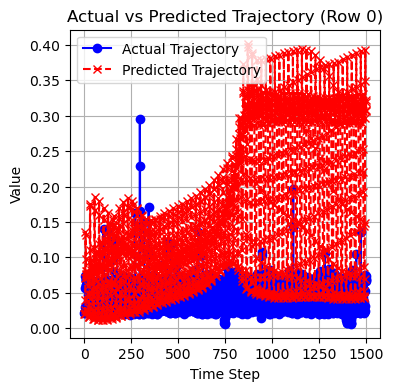

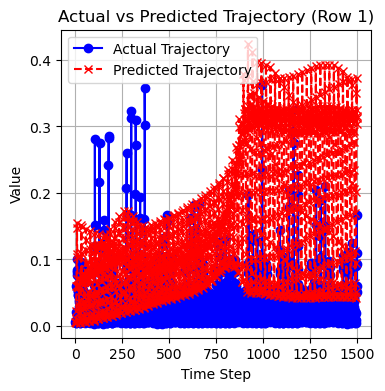

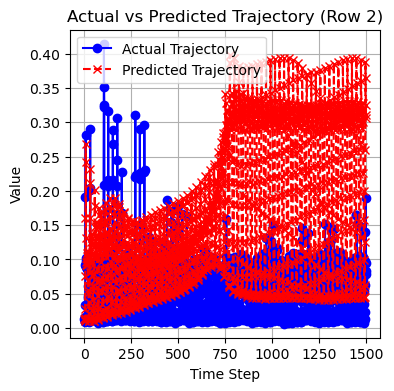

In [7]:
for row_idx in range(3):
    initial_input = val_set[row_idx, :window_length].unsqueeze(0)

    # Use the previously generated prediction for the validation set
    predicted_trajectory = val_predictions_tensor[row_idx].cpu().numpy()

    # Get the actual trajectory for comparison
    actual_trajectory = val_set[row_idx].cpu().numpy()

    # Plot the actual vs predicted trajectory
    plt.figure(figsize=(4, 4))
    plt.plot(range(len(actual_trajectory)), actual_trajectory, label="Actual Trajectory", color="blue", marker="o")
    plt.plot(range(len(predicted_trajectory)), predicted_trajectory, label="Predicted Trajectory", color="red", linestyle="--", marker="x")
    plt.title(f"Actual vs Predicted Trajectory (Row {row_idx})")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"trajectory_{row_idx}.png", dpi=200)
    plt.show()

In [8]:
# Generate predictions for the test dataset
initial_input = val_predictions_tensor[:, -window_length:]
test_predictions_tensor = autoregressive_predict(model, initial_input, test_set.shape[1])

print(f"Test Predictions Tensor Shape: {test_predictions_tensor.shape}")

Test Predictions Tensor Shape: torch.Size([963, 1500])


In [9]:
def generate_submissions_v4(pred_val_tensor, pred_test_tensor, original_val_path, original_test_path):
    # Read the original validation and testing datasets
    original_val_df = pd.read_csv(original_val_path)
    original_test_df = pd.read_csv(original_test_path)

    # Ensure the shape of pred_val_tensor and pred_test_tensor is correct
    assert pred_val_tensor.shape[0] * pred_val_tensor.shape[1] == original_val_df.shape[0] * (original_val_df.shape[1] - 1)
    assert pred_test_tensor.shape[0] * pred_test_tensor.shape[1] == original_test_df.shape[0] * (original_test_df.shape[1] - 1)

    # Create empty lists to store ids and values
    ids = []
    values = []

    # Process validation set
    for col_idx, col in enumerate(original_val_df.columns[1:]):  # Skip the 'ids' column
        for row_idx, _ in enumerate(original_val_df[col]):
            ids.append(str(f"{col}_traffic_val_{row_idx}"))
            values.append(float(pred_val_tensor[row_idx, col_idx]))

    # Process testing set
    for col_idx, col in enumerate(original_test_df.columns[1:]):  # Skip the 'ids' column
        for row_idx, _ in enumerate(original_test_df[col]):
            ids.append(str(f"{col}_traffic_test_{row_idx}"))
            values.append(float(pred_test_tensor[row_idx, col_idx]))

    # Create the submissions dataframe
    submissions_df = pd.DataFrame({"ids": ids, "value": values})

    # Impute any null values
    submissions_df.fillna(100, inplace=True)

    # Assert the shape of the dataframe
    assert submissions_df.shape[1] == 2
    assert submissions_df.shape[0] == (original_val_df.shape[0] * (original_val_df.shape[1] - 1)) + (
        original_test_df.shape[0] * (original_test_df.shape[1] - 1)
    )
    assert "ids" in submissions_df.columns
    assert "value" in submissions_df.columns

    # Save to CSV
    submissions_df.to_csv("submissions_v3.csv", index=False)


# Call the function
generate_submissions_v4(val_predictions_tensor, test_predictions_tensor, val_path, test_path)